In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

sns.set(rc={"figure.figsize": (9, 5)})
sns.set_style("white")

# current_palette = sns.color_palette("Paired")
# sns.set_palette(current_palette)

In [2]:
FILE = '../Сводная вегетация.xlsx'
YEARS = [2012, 2013, 2014, 2015, 2016]

## Building a table of data

In [3]:
def get_year_culture_week_ndvi():
    data = pd.DataFrame(columns = ['year', 'culture', 'week', 'ndvi'])
    
    for year in YEARS:
        df = pd.read_excel(FILE, sheetname=str(year), header=1)

        ndvi_columns = [col for col in df.columns if 'неделя' in col]
        culture_column = 'Культура ' + str(year)
        interesting_columns = [culture_column], ndvi_columns
        
        df = df[[culture_column] + ndvi_columns]
        data_array = []
        
        for i in range(df.shape[0]):
            for j in range(1, df.shape[1]):
                culture = df.iloc[i][culture_column]
                week = int(df.columns[j].replace('неделя ', ''))
                ndvi = df.iloc[i, j]
                
                row = [year, culture, week, ndvi]
                data_array.append(row)
                
        data_array = np.array(data_array)
        data_frame = pd.DataFrame(data_array, columns=data.columns)
        data = pd.concat([data, data_frame[data_frame['ndvi'] != 'nan']])
        
    return data

In [4]:
df = get_year_culture_week_ndvi()

In [5]:
df.dtypes

year       object
culture    object
week       object
ndvi       object
dtype: object

In [6]:
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)
df['ndvi'] = df['ndvi'].astype(float)

df.dtypes

year         int64
culture     object
week         int64
ndvi       float64
dtype: object

## Encoding categorical variables

In [7]:
le = LabelEncoder()
df['culture'] = le.fit_transform(df['culture'])
df.head()

,year,culture,week,ndvi
5,2012,4,48,0.382
6,2012,4,47,0.380
8,2012,4,45,0.353
10,2012,4,43,0.341
11,2012,4,42,0.354


## Train / test split

In [8]:
df_train = df[df['year'] != 2015]
df_test = df[df['year'] == 2015]

In [9]:
X_train = df_train[['culture', 'week']]
X_test = df_test[['culture', 'week']]

y_train = df_train['ndvi']
y_test = df_test['ndvi']

print('X_train.shape:\t', X_train.shape)
print('X_test.shape:\t', X_test.shape)
print('y_train.shape:\t', y_train.shape)
print('y_test.shape:\t', y_test.shape)

X_train.shape:	 (17022, 2)
X_test.shape:	 (7204, 2)
y_train.shape:	 (17022,)
y_test.shape:	 (7204,)


In [10]:
X_train.head()

,culture,week
5,4,48
6,4,47
8,4,45
10,4,43
11,4,42


## Real NDVI of 2015 averaged over fields (one value per week and culture)

In [11]:
def plot_culture_year(culture, year):
    df_mean_ndvi = df.groupby(['year', 'culture', 'week']).mean()

    df_yc = df_mean_ndvi[
        (df_mean_ndvi.index.get_level_values('year') == year) &
        (df_mean_ndvi.index.get_level_values('culture') == culture)]

    week = df_yc.index.get_level_values('week')
    ndvi = df_yc['ndvi']
    
    plt.plot(week, ndvi)

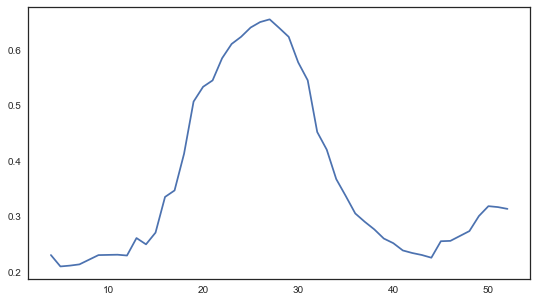

In [12]:
sns.despine()
plot_culture_year(4, 2015)

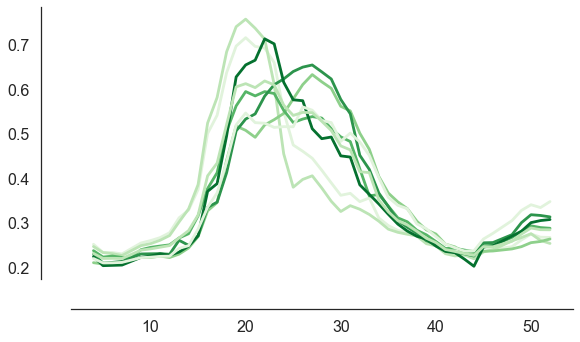

In [13]:
#sns.set(rc={"figure.figsize": (15, 9)})
sns.set_context("poster")
sns.set_style("white")
sns.set_palette('Greens')

cult15 = df[df['year'] == 2015]['culture'].unique()

for cult in cult15:
    plot_culture_year(cult, 2015)
    
sns.despine(offset=30)
plt.savefig('../img/ndvi-bugn.png')

## Predicting that NDVI

In [14]:
weeks = [i + 1 for i in range(52)]

def plot_ndvi(culture, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    cult_df = pd.DataFrame({
        'culture': [culture for _ in range(len(weeks))],
        'week': weeks
    })

    ndvi = model.predict(cult_df)
    plt.plot(weeks, ndvi)
    
    return r2

In [15]:
def plot_all_ndvi(model):
    scores = []
    for cult in X_test['culture'].unique():
        r2 = plot_ndvi(cult, model)
        scores.append(r2)
        
    print('r2_score:', np.array(scores).mean())

r2_score: -0.168651420113


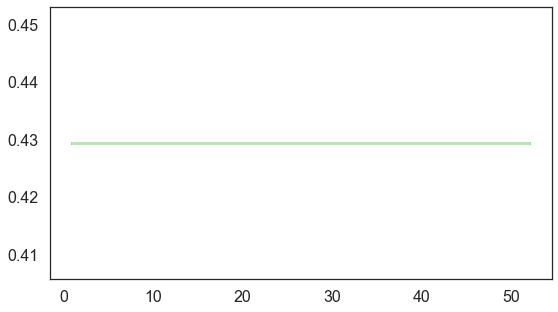

In [16]:
plot_all_ndvi(DummyRegressor())

r2_score: 0.557883466401


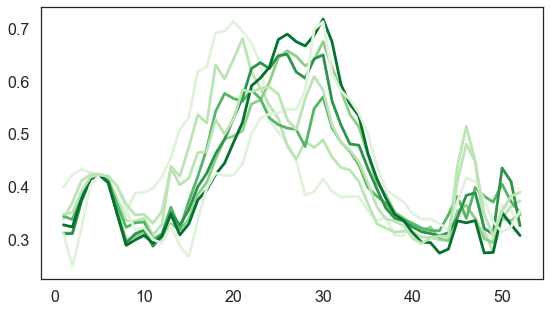

In [17]:
plot_all_ndvi(SVR())

r2_score: 0.574376691018


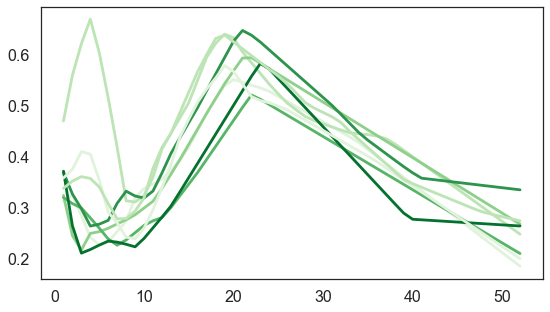

In [18]:
plot_all_ndvi(MLPRegressor())

In [19]:
def plot_ridge(degree):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    plot_all_ndvi(model)

r2_score: 0.379120285035


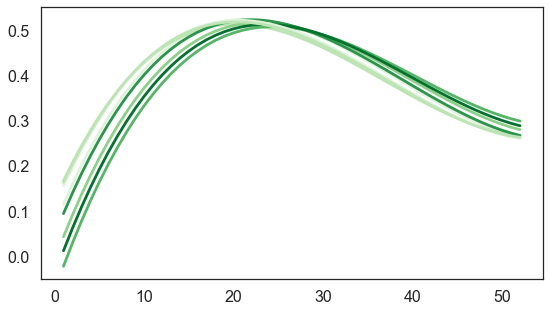

In [20]:
plot_ridge(degree=3)

r2_score: 0.529042530555


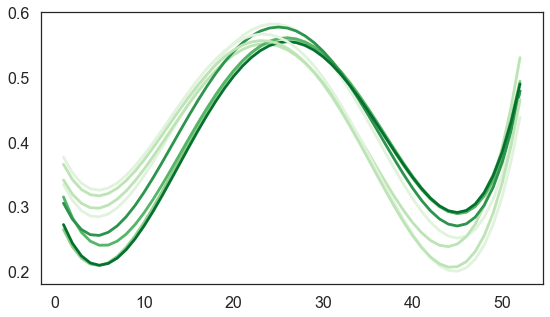

In [21]:
plot_ridge(degree=4)

r2_score: 0.604678078977


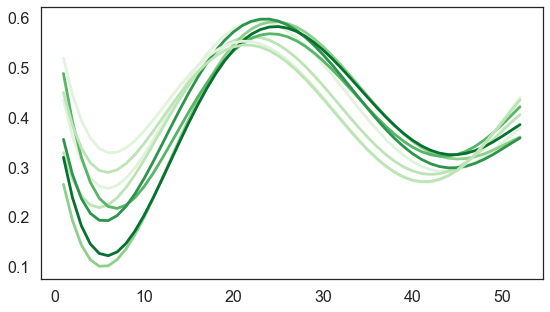

In [22]:
plot_ridge(degree=5)

r2_score: 0.617012574918


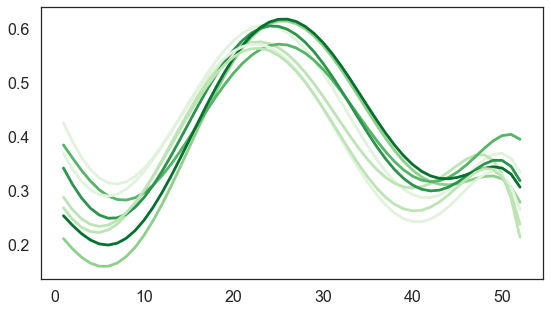

In [23]:
plot_ridge(degree=6)

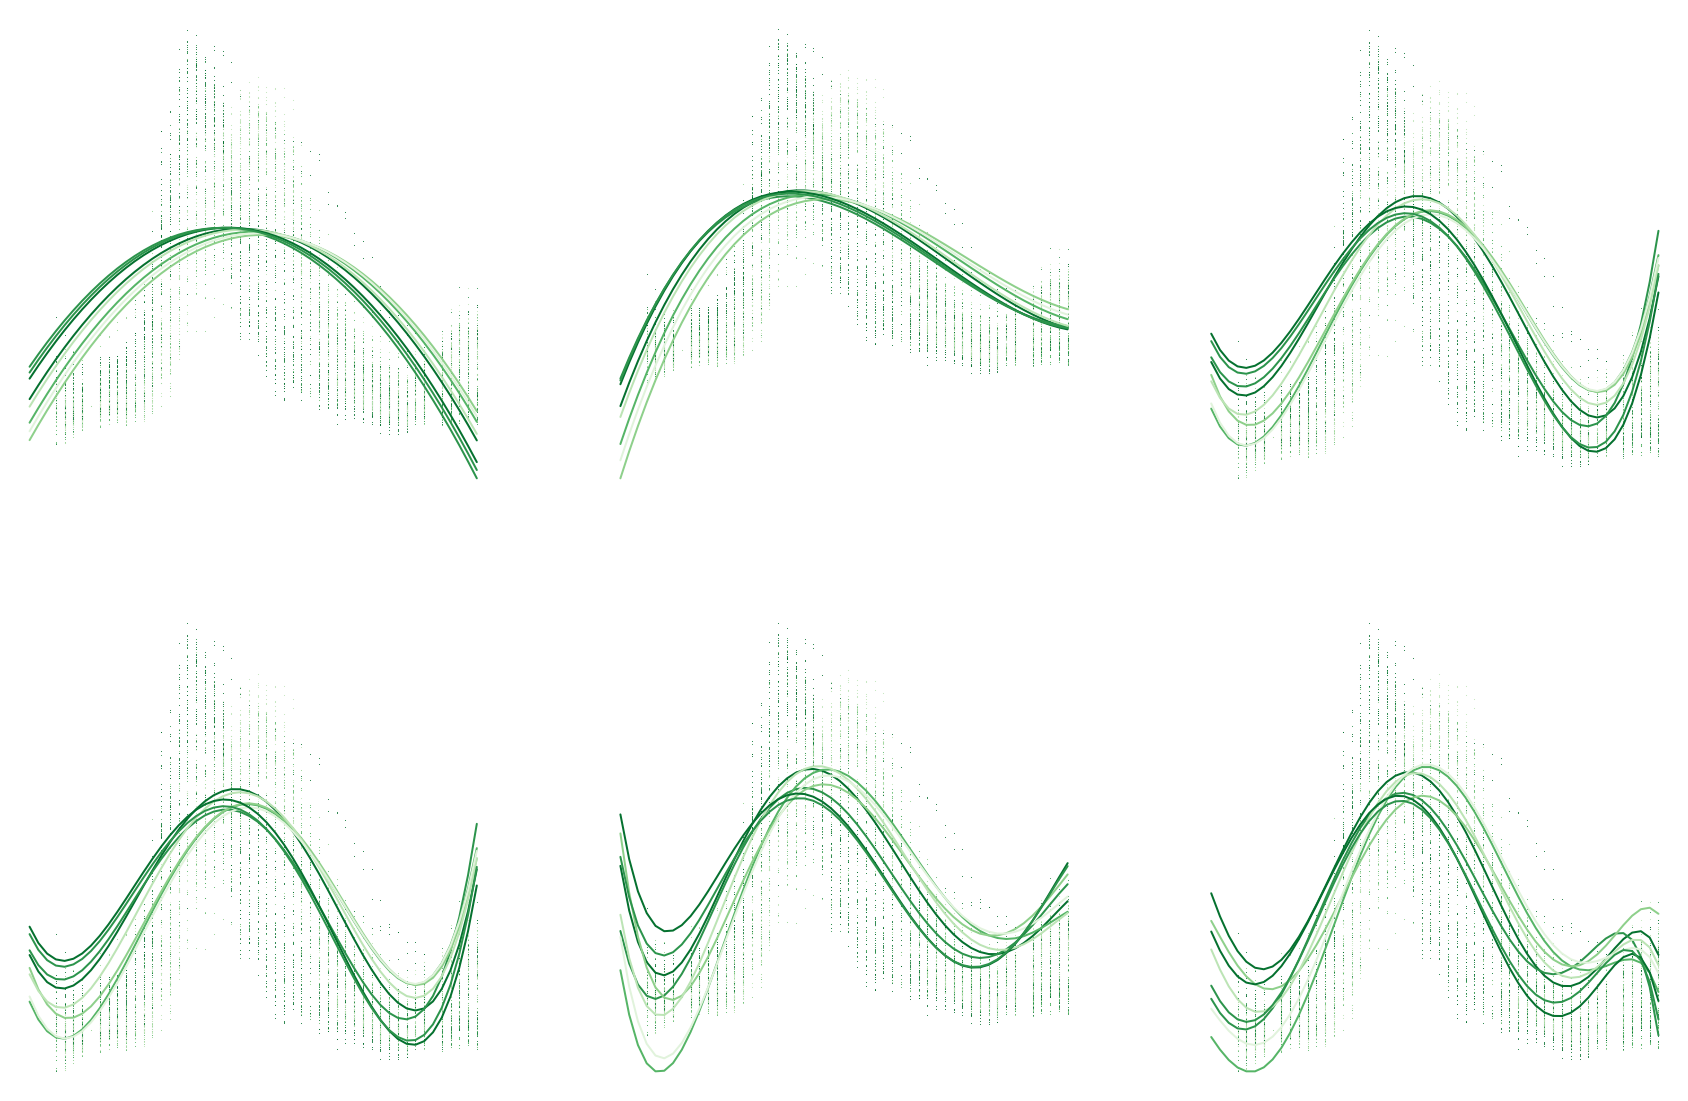

In [24]:
sns.set(rc={"figure.figsize": (30, 20)})
sns.set_style('white')
sns.set_palette('Greens_r')

fig, axes = plt.subplots(2, 3)

for i in range(2):
    for j in range(3):
        for cult in X_test['culture'].unique():
            degree = 2 + 2 * i + j
            model = make_pipeline(PolynomialFeatures(degree), Ridge())
            model.fit(X_train, y_train)

            cult_df = pd.DataFrame({
                'culture': [cult for _ in range(len(weeks))],
                'week': weeks
            })

            ndvi = model.predict(cult_df)
            axes[i,j].scatter(X_test[X_test['culture'] == cult]['week'], y_test[X_test['culture'] == cult], s=0.5)
            axes[i,j].plot(weeks, ndvi, linewidth=2)
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            
sns.despine(left=True, bottom=True)
plt.savefig('../img/ridge.png')

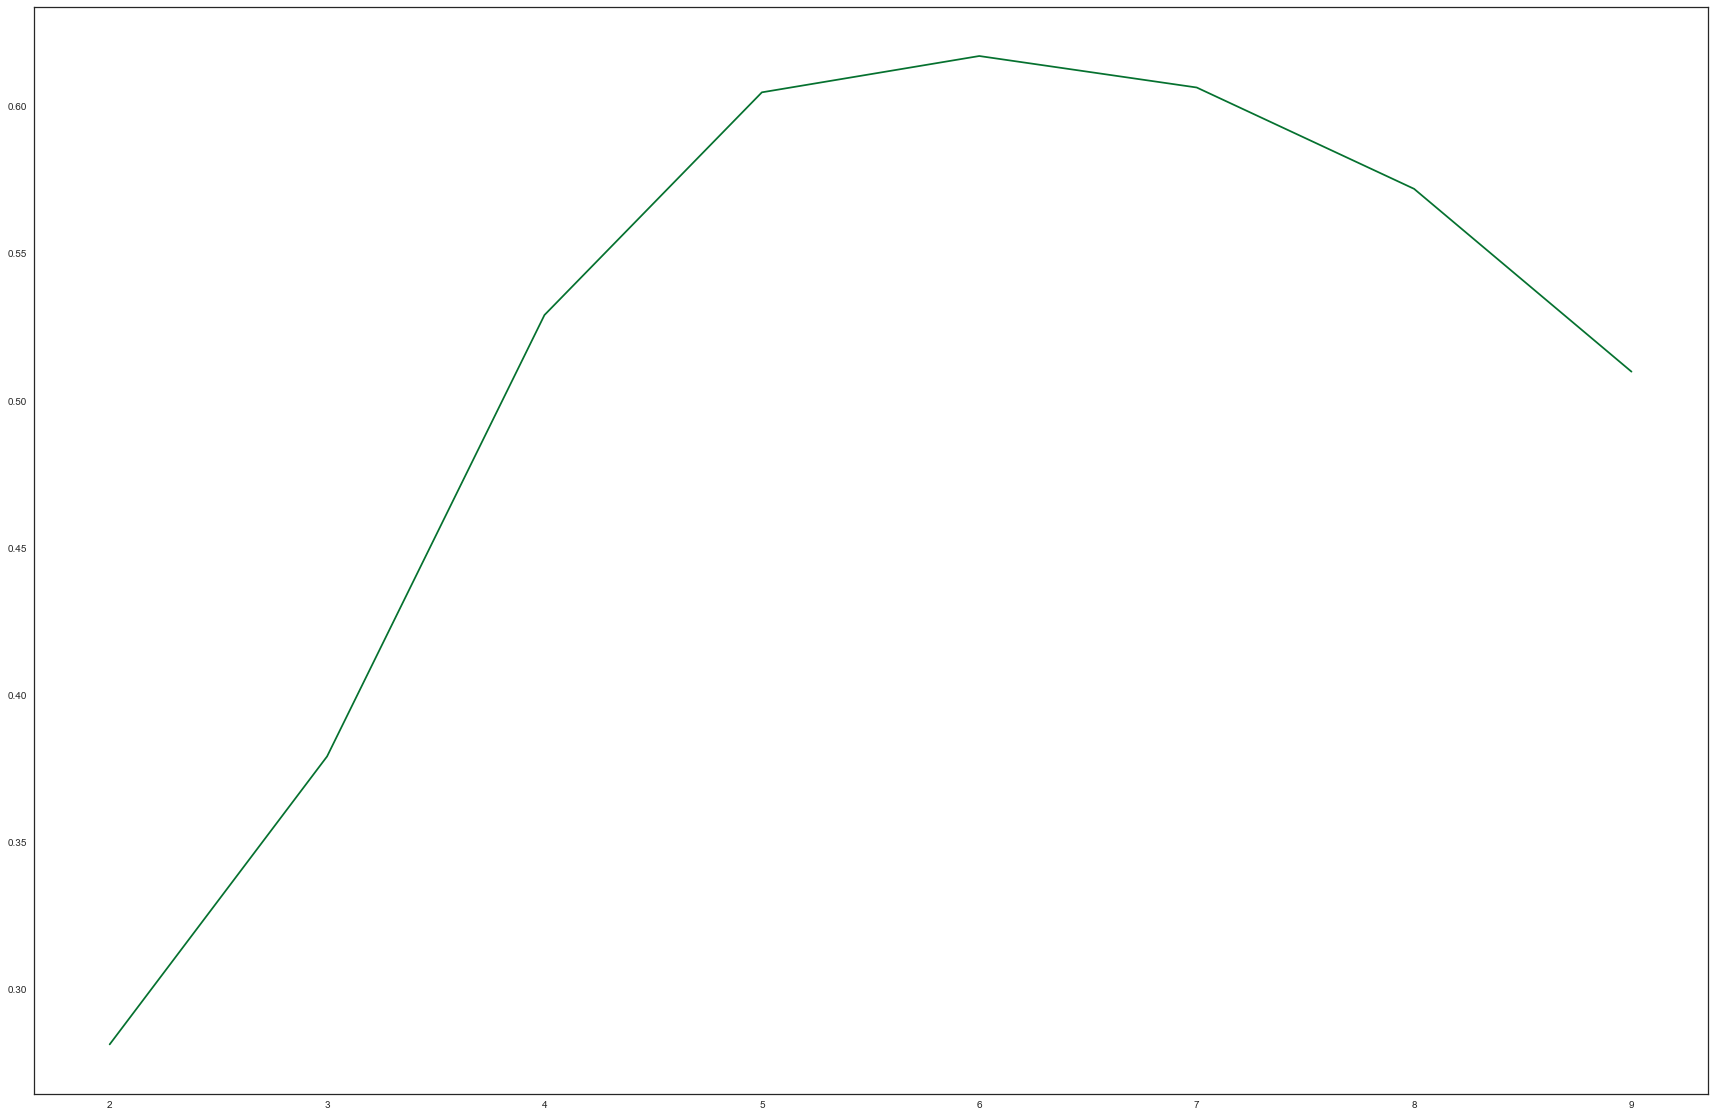

In [25]:
r2s = []
degrees = [2, 3, 4, 5, 6, 7, 8, 9]

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)
    
plt.plot(degrees, r2s)

In [26]:
df_diff = df[df['year'] == 2015].copy()
df_diff['ndvi'] -= y_pred
df_diff.head()

,year,culture,week,ndvi
0,2015,5,52,-0.052275
1,2015,5,51,-0.079112
2,2015,5,50,-0.047894
3,2015,5,49,-0.036992
4,2015,5,48,-0.027172


In [27]:
def plot_diff(culture):
    df_diff_cult = df_diff[df_diff['culture'] == culture].groupby('week').mean()
    ndvi = df_diff_cult['ndvi']

    print(le.inverse_transform(culture))
    return ndvi.plot(kind='bar', figsize=(13, 4), color='#4baf9c')

Подсолнечник


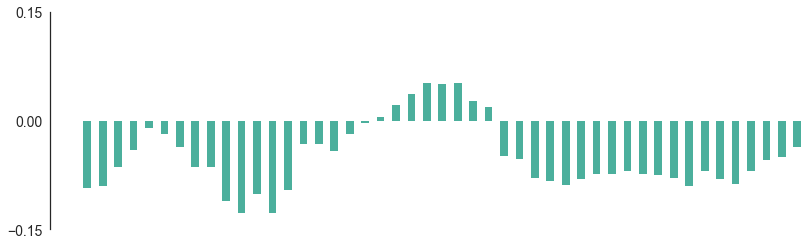

In [28]:
sns.set(rc={"figure.figsize": (10, 8)})
sns.set_style('white')
sns.set_palette('pastel')
f = plot_diff(4)
sns.despine(offset=30, bottom=True)
f.set_ylim([-0.15, 0.15])
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_ticks([-0.15, 0, 0.15])
f.tick_params(labelsize=14)

plt.savefig('../img/sunflower-ndvi-diff-gn.png')

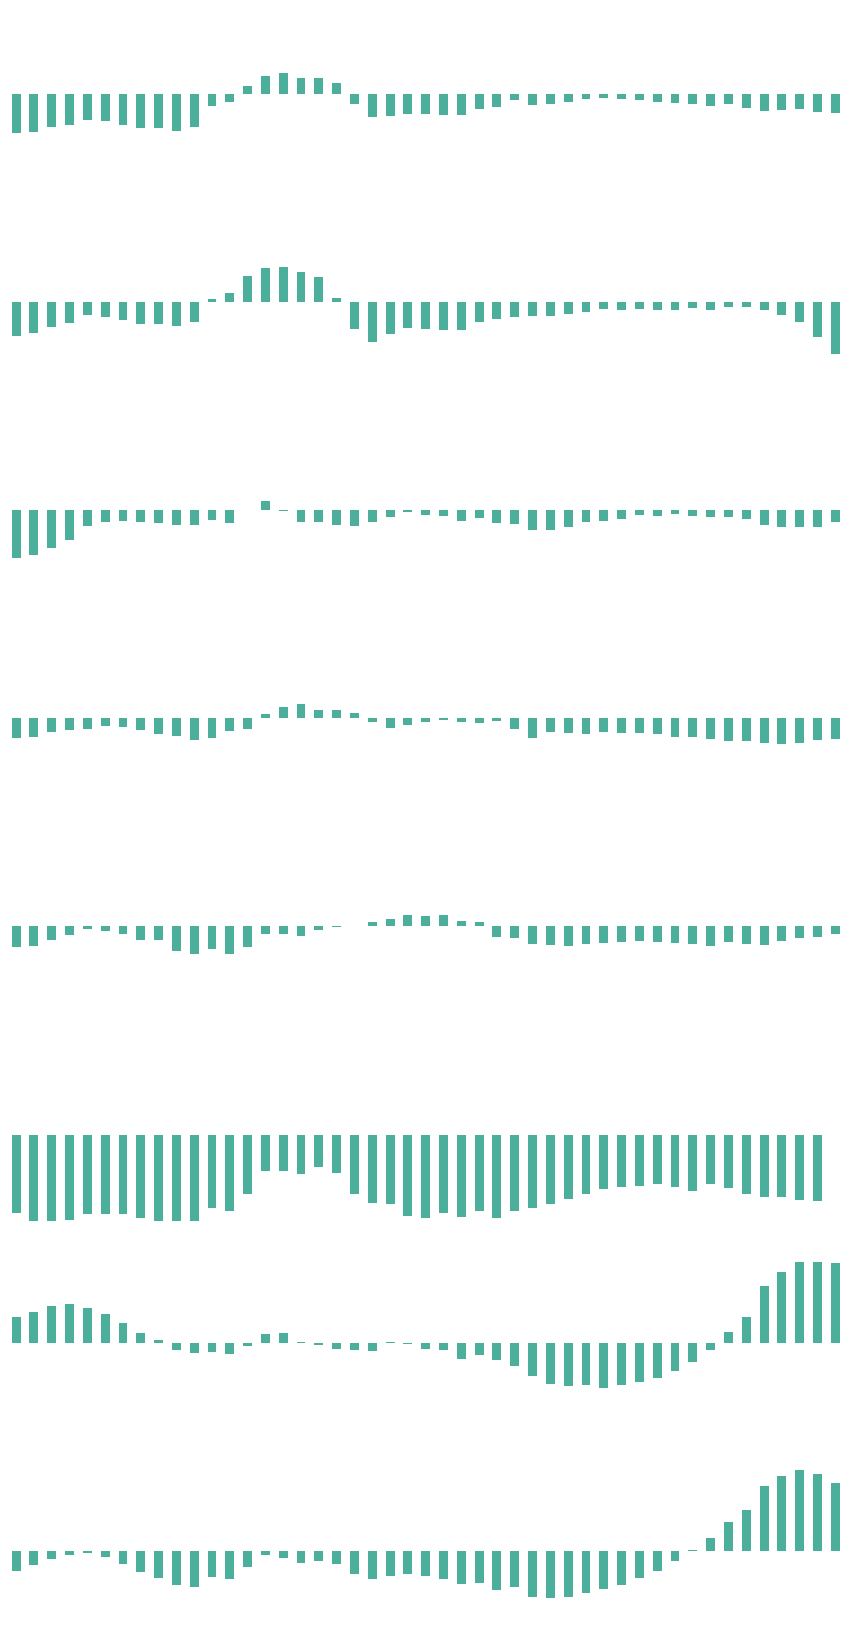

In [29]:
fig, axes = plt.subplots(len(cult15), sharex=True)
fig.set_size_inches(15, 30, forward=True)

for i in range(len(cult15)):
    df_diff_cult = df_diff[df_diff['culture'] == cult15[i]].groupby('week').mean()
    ndvi = df_diff_cult['ndvi']

    ndvi.plot(kind='bar', ax=axes[i], color='#4baf9c')
    #axes[i].set_title(le.inverse_transform(cult15[i]), fontsize=16)
    axes[i].set_ylim([-0.3, 0.3])
    axes[i].get_xaxis().set_visible(False)
    sns.despine(offset=30, bottom=True, left=True)
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_ticks([-0.4, 0, 0.4])
    axes[i].tick_params(labelsize=14)
    
plt.savefig('../img/all-ndvi-diff.png')